In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [2]:
!pip install keras==2.2.4

In [3]:
import os
import numpy as np
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
if (sklearn.__version__ == '0.20.0'):
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import StratifiedShuffleSplit


#======================================
# Global definitions
#======================================
n_epochs         = 100
learning_rate    = 1e-4
n_classes        = 10
train_batch_size = 32
val_batch_size   = 10
    
#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

The scikit-learn version is 0.20.0.


Using TensorFlow backend.


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [4]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [5]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

#=====================================
# Prepare the data
#=====================================

#--- Dividing the data into training and validation
folds = 5
if (sklearn.__version__ == '0.20.0'):
    sss = StratifiedShuffleSplit(folds, test_size=0.2, random_state=42)
    sss = sss.split(trainVal_data,trainVal_label)
else:
    sss = StratifiedShuffleSplit(trainVal_label, folds, test_size=0.2, random_state=42)
X_train = []
y_train = []
X_val = []
y_val = []
for train_index, val_index in sss:
    X_train.append(trainVal_data[train_index])
    X_val.append(trainVal_data[val_index])
    y_train.append(trainVal_label[train_index])
    y_val.append(trainVal_label[val_index])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
    
print("--- Splitting data into train and val")
print("Train data. X:",X_train.shape,"Y:",y_train.shape)
print("Val data. X:",X_val.shape,"Y:",y_val.shape)

#--- Data augmentation
aug = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                         rotation_range=20, 
                         width_shift_range=0.2, height_shift_range=0.2, 
                         horizontal_flip=True, vertical_flip=True, 
                         fill_mode='nearest')

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
--- Splitting data into train and val
Train data. X: (5, 40000, 32, 32, 3) Y: (5, 40000, 1)
Val data. X: (5, 10000, 32, 32, 3) Y: (5, 10000, 1)


[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


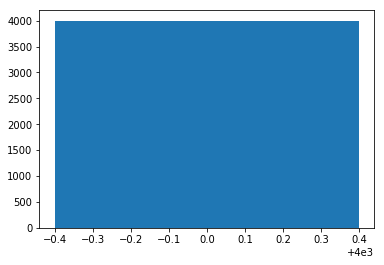

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


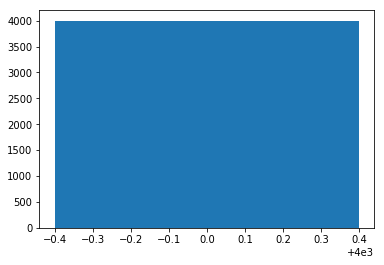

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


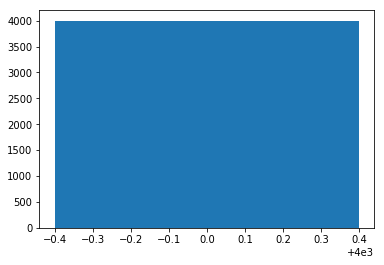

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


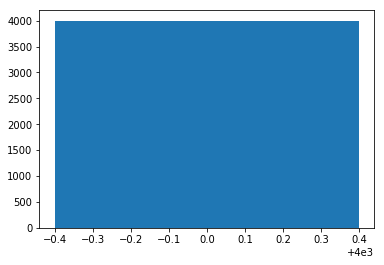

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


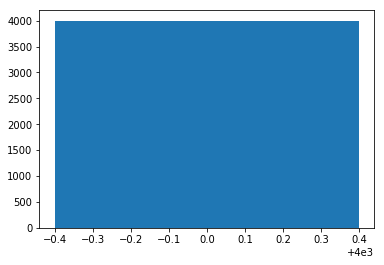

<Figure size 432x288 with 0 Axes>

In [6]:
# Cheking if the splits are balanced
for i in range(folds):
    hist = np.histogram(np.squeeze(y_train[i]))[0]
    print(hist)    
    plt.bar(hist,np.amax(hist),alpha=0.5)
    plt.show()
    plt.clf()

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [7]:
def get_squeezenet_ft():
    #=====================================
    # Freezing layers
    #=====================================

    squeezeNetModel = SqueezeNet((32,32,3))

    #freeze layers
    for layer in squeezeNetModel.layers:
        layer.trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.summary()
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax
    squeezeNetModel.summary()

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    #=====================================
    # Compile model
    #=====================================

    #--- Compile the model
    # It means to configure the model for training.
    # Other types of optimizer:
    #    optimizers.Adam(lr=learning_rate)
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model 
model  = get_squeezenet_ft()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [8]:


#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
#model.save_weights("temp.h5")
for i in range(folds):
    model  = get_squeezenet_ft()
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    #print("Optimizer:",opt)
    print("================================================")
    # Training with data augmentation
    '''
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
    '''
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=2, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1)
    #--- Evaluating the model for split i
    score = score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    model.load_weights("temp.h5") #avoid overfitting
    
#--- Showing scores
print(scores)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 7s 169us/step - loss: 5.3216 - acc: 0.1115 - val_loss: 2.3109 - val_acc: 0.1052
Epoch 2/2
10000/10000 [==============================] - 3s 254us/step
Validation loss: 2.3030051221847536
Validation accuracy (NORMALIZED): 0.09980000189691782
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0    

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 6s 151us/step - loss: 5.4345 - acc: 0.1151 - val_loss: 2.3104 - val_acc: 0.1026
Epoch 2/2
10000/10000 [==============================] - 3s 260us/step
Validation loss: 2.30229803609848
Validation accuracy (NORMALIZED): 0.1000000019222498
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0       

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 6s 159us/step - loss: 5.2147 - acc: 0.1055 - val_loss: 2.3000 - val_acc: 0.1006
Epoch 2/2
10000/10000 [==============================] - 2s 243us/step
Validation loss: 2.302048394441605
Validation accuracy (NORMALIZED): 0.10030000187456607
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0     

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 7s 183us/step - loss: 5.2060 - acc: 0.1091 - val_loss: 2.3047 - val_acc: 0.1048
Epoch 2/2
10000/10000 [==============================] - 2s 242us/step
Validation loss: 2.3024360327720643
Validation accuracy (NORMALIZED): 0.10060000187158584
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_6[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0    

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 7s 167us/step - loss: 5.5148 - acc: 0.1212 - val_loss: 2.3038 - val_acc: 0.1028
Epoch 2/2
10000/10000 [==============================] - 3s 256us/step
Validation loss: 2.3025289046764374
Validation accuracy (NORMALIZED): 0.10010000187158584
[[2.3030051221847536, 0.09980000189691782], [2.30229803609848, 0.1000000019222498], [2.302048394441605, 0.10030000187456607], [2.3024360327720643, 0.10060000187158584], [2.3025289046764374, 0.10010000187158584]]


Finally, let's evaluate on our test set:

In [9]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 2.302463298034668
Mean Validation accuracy (NORMALIZED): 0.10016000188738108


-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [10]:
def get_squeezenet_ft2():
    squeezeNetModel = SqueezeNet((32,32,3))

    #print([layer.name for layer in squeezeNetModel.layers])
    #print(squeezeNetModel.layers[-19].name)
    #print(len(squeezeNetModel.layers))

    #=====================================
    # Freezing mentioned layers
    #=====================================

    trainable_layer_index = 19
    for i in range(len(squeezeNetModel.layers)-trainable_layer_index):
        squeezeNetModel.layers[i].trainable = False

    #--- Check the trainable status of the individual layers
    for layer in squeezeNetModel.layers:
        print(layer.name, " ----- ", layer.trainable)

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax
    squeezeNetModel.summary()

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

Now, we compile our model and train it:

In [11]:
#=====================================
# Compile model
#=====================================

#--- Compile the model
# It means to configure the model for training.
# Other types of optimizer:
#    optimizers.Adam(lr=1e-3)

#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    model = get_squeezenet_ft2()    
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    #print("Optimizer:",opt)
    print("================================================")
    # Training with data augmentation
    '''
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
    '''
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),              
              verbose=1)
    #--- Evaluating the model for split i
    score = score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    #model.load_weights("temp.h5") #avoid overfitting
    
#--- Showing scores
print(scores)

input_7  -----  False
conv1  -----  False
relu_conv1  -----  False
pool1  -----  False
fire2/squeeze1x1  -----  False
fire2/relu_squeeze1x1  -----  False
fire2/expand1x1  -----  False
fire2/expand3x3  -----  False
fire2/relu_expand1x1  -----  False
fire2/relu_expand3x3  -----  False
fire2/concat  -----  False
fire3/squeeze1x1  -----  False
fire3/relu_squeeze1x1  -----  False
fire3/expand1x1  -----  False
fire3/expand3x3  -----  False
fire3/relu_expand1x1  -----  False
fire3/relu_expand3x3  -----  False
fire3/concat  -----  False
pool3  -----  False
fire4/squeeze1x1  -----  False
fire4/relu_squeeze1x1  -----  False
fire4/expand1x1  -----  False
fire4/expand3x3  -----  False
fire4/relu_expand1x1  -----  False
fire4/relu_expand3x3  -----  False
fire4/concat  -----  False
fire5/squeeze1x1  -----  False
fire5/relu_squeeze1x1  -----  False
fire5/expand1x1  -----  False
fire5/expand3x3  -----  False
fire5/relu_expand1x1  -----  False
fire5/relu_expand3x3  -----  False
fire5/concat  -----  Fal

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 10s 255us/step - loss: 2.3896 - acc: 0.1617 - val_loss: 2.0943 - val_acc: 0.2752
Epoch 2/100
40000/40000 [==============================] - 9s 226us/step - loss: 2.0876 - acc: 0.2591 - val_loss: 1.8886 - val_acc: 0.3684
Epoch 3/100
40000/40000 [==============================] - 9s 234us/step - loss: 1.9912 - acc: 0.3029 - val_loss: 1.8142 - val_acc: 0.3954
Epoch 4/100
40000/40000 [==============================] - 10s 240us/step - loss: 1.8916 - acc: 0.3285 - val_loss: 1.6819 - val_acc: 0.4226
Epoch 5/100
40000/40000 [==============================] - 10s 247us/step - loss: 1.8144 - acc: 0.3489 - val_loss: 1.6103 - val_acc: 0.4471
Epoch 6/100
40000/40000 [==============================] - 9s 235us/step - loss: 1.7710 - acc: 0.3620 - val_loss: 1.6026 - val_acc: 0.4442
Epoch 7/100
40000/40000 [==============================] - 9s 233us/step - loss: 1.7299 - acc: 0.3862 - val_loss:

40000/40000 [==============================] - 10s 239us/step - loss: 1.0291 - acc: 0.6278 - val_loss: 1.5809 - val_acc: 0.5034
Epoch 60/100
40000/40000 [==============================] - 9s 231us/step - loss: 1.0175 - acc: 0.6332 - val_loss: 1.6148 - val_acc: 0.5083
Epoch 61/100
40000/40000 [==============================] - 9s 235us/step - loss: 1.0130 - acc: 0.6343 - val_loss: 1.6013 - val_acc: 0.5051
Epoch 62/100
40000/40000 [==============================] - 9s 227us/step - loss: 1.0041 - acc: 0.6358 - val_loss: 1.5919 - val_acc: 0.5051
Epoch 63/100
40000/40000 [==============================] - 9s 229us/step - loss: 0.9969 - acc: 0.6381 - val_loss: 1.6501 - val_acc: 0.5025
Epoch 64/100
40000/40000 [==============================] - 9s 235us/step - loss: 0.9883 - acc: 0.6432 - val_loss: 1.6170 - val_acc: 0.5029
Epoch 65/100
40000/40000 [==============================] - 9s 236us/step - loss: 0.9783 - acc: 0.6431 - val_loss: 1.6618 - val_acc: 0.5055
Epoch 66/100
40000/40000 [======

Split: 1
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 269us/step - loss: 2.3600 - acc: 0.1849 - val_loss: 1.9972 - val_acc: 0.3241
Epoch 2/100
40000/40000 [==============================] - 10s 239us/step - loss: 2.0261 - acc: 0.2570 - val_loss: 1.7922 - val_acc: 0.3843
Epoch 3/100
40000/40000 [==============================] - 10s 243us/step - loss: 1.9170 - acc: 0.2996 - val_loss: 1.7176 - val_acc: 0.4064
Epoch 4/100
40000/40000 [==============================] - 9s 236us/step - loss: 1.8408 - acc: 0.3320 - val_loss: 1.6708 - val_acc: 0.4176
Epoch 5/100
40000/40000 [==============================] - 10s 240us/step - loss: 1.7865 - acc: 0.3504 - val_loss: 1.6206 - val_acc: 0.4384
Epoch 6/100
40000/40000 [==============================] - 10s 241us/step - loss: 1.7448 - acc: 0.3720 - val_loss: 1.6038 - val_acc: 0.4360
Epoch 7/

40000/40000 [==============================] - 9s 220us/step - loss: 1.0600 - acc: 0.6145 - val_loss: 1.5804 - val_acc: 0.5069
Epoch 58/100
40000/40000 [==============================] - 9s 220us/step - loss: 1.0519 - acc: 0.6184 - val_loss: 1.5741 - val_acc: 0.4975
Epoch 59/100
40000/40000 [==============================] - 9s 221us/step - loss: 1.0432 - acc: 0.6213 - val_loss: 1.5918 - val_acc: 0.4966
Epoch 60/100
40000/40000 [==============================] - 9s 221us/step - loss: 1.0384 - acc: 0.6220 - val_loss: 1.6096 - val_acc: 0.4947
Epoch 61/100
40000/40000 [==============================] - 9s 222us/step - loss: 1.0279 - acc: 0.6267 - val_loss: 1.6433 - val_acc: 0.5040
Epoch 62/100
40000/40000 [==============================] - 9s 222us/step - loss: 1.0181 - acc: 0.6291 - val_loss: 1.5975 - val_acc: 0.4980
Epoch 63/100
40000/40000 [==============================] - 9s 222us/step - loss: 1.0089 - acc: 0.6326 - val_loss: 1.6628 - val_acc: 0.5007
Epoch 64/100
40000/40000 [=======

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 287us/step - loss: 2.3633 - acc: 0.1924 - val_loss: 1.9625 - val_acc: 0.3501
Epoch 2/100
40000/40000 [==============================] - 10s 250us/step - loss: 1.9885 - acc: 0.2867 - val_loss: 1.7326 - val_acc: 0.4089
Epoch 3/100
40000/40000 [==============================] - 10s 247us/step - loss: 1.8533 - acc: 0.3349 - val_loss: 1.6432 - val_acc: 0.4372
Epoch 4/100
40000/40000 [==============================] - 10s 251us/step - loss: 1.7902 - acc: 0.3579 - val_loss: 1.5801 - val_acc: 0.4508
Epoch 5/100
40000/40000 [==============================] - 10s 246us/step - loss: 1.7401 - acc: 0.3750 - val_loss: 1.5763 - val_acc: 0.4630
Epoch 6/100
40000/40000 [==============================] - 10s 242us/step - loss: 1.7015 - acc: 0.3919 - val_loss: 1.5557 - val_acc: 0.4695
Epoch 7/100
40000/40000 [==============================] - 10s 247us/step - loss: 1.6786 - acc: 0.4049 - val_l

Epoch 59/100
40000/40000 [==============================] - 10s 240us/step - loss: 1.0659 - acc: 0.6170 - val_loss: 1.5647 - val_acc: 0.5093
Epoch 60/100
40000/40000 [==============================] - 9s 237us/step - loss: 1.0558 - acc: 0.6216 - val_loss: 1.5871 - val_acc: 0.5132
Epoch 61/100
40000/40000 [==============================] - 10s 238us/step - loss: 1.0482 - acc: 0.6214 - val_loss: 1.5881 - val_acc: 0.5112
Epoch 62/100
40000/40000 [==============================] - 10s 239us/step - loss: 1.0380 - acc: 0.6252 - val_loss: 1.5765 - val_acc: 0.5105
Epoch 63/100
40000/40000 [==============================] - 10s 240us/step - loss: 1.0309 - acc: 0.6276 - val_loss: 1.6148 - val_acc: 0.5116
Epoch 64/100
40000/40000 [==============================] - 10s 238us/step - loss: 1.0212 - acc: 0.6297 - val_loss: 1.5838 - val_acc: 0.5113
Epoch 65/100
40000/40000 [==============================] - 10s 239us/step - loss: 1.0113 - acc: 0.6348 - val_loss: 1.5881 - val_acc: 0.5110
Epoch 66/100
4

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 274us/step - loss: 2.3492 - acc: 0.1867 - val_loss: 1.9735 - val_acc: 0.3317
Epoch 2/100
40000/40000 [==============================] - 9s 236us/step - loss: 2.0302 - acc: 0.2711 - val_loss: 1.8424 - val_acc: 0.3896
Epoch 3/100
40000/40000 [==============================] - 9s 236us/step - loss: 1.9238 - acc: 0.3168 - val_loss: 1.7488 - val_acc: 0.4158
Epoch 4/100
40000/40000 [==============================] - 9s 233us/step - loss: 1.8491 - acc: 0.3425 - val_loss: 1.6836 - val_acc: 0.4308
Epoch 5/100
40000/40000 [==============================] - 9s 234us/step - loss: 1.8011 - acc: 0.3621 - val_loss: 1.6178 - val_acc: 0.4455
Epoch 6/100
40000/40000 [==============================] - 10s 239us/step - loss: 1.7513 - acc: 0.3716 - val_loss: 1.5980 - val_acc: 0.4476
Epoch 7/100
40000/40000 [==============================] - 10s 241us/step - loss: 1.7193 - acc: 0.3854 - val_loss:

40000/40000 [==============================] - 9s 233us/step - loss: 1.0481 - acc: 0.6203 - val_loss: 1.5986 - val_acc: 0.5144
Epoch 60/100
40000/40000 [==============================] - 9s 232us/step - loss: 1.0401 - acc: 0.6217 - val_loss: 1.5513 - val_acc: 0.5158
Epoch 61/100
40000/40000 [==============================] - 9s 232us/step - loss: 1.0362 - acc: 0.6238 - val_loss: 1.6097 - val_acc: 0.5141
Epoch 62/100
40000/40000 [==============================] - 10s 241us/step - loss: 1.0268 - acc: 0.6298 - val_loss: 1.6737 - val_acc: 0.5104
Epoch 63/100
40000/40000 [==============================] - 10s 245us/step - loss: 1.0228 - acc: 0.6281 - val_loss: 1.6104 - val_acc: 0.5112
Epoch 64/100
40000/40000 [==============================] - 10s 247us/step - loss: 1.0082 - acc: 0.6318 - val_loss: 1.6988 - val_acc: 0.5084
Epoch 65/100
40000/40000 [==============================] - 10s 248us/step - loss: 1.0000 - acc: 0.6361 - val_loss: 1.6422 - val_acc: 0.5101
Epoch 66/100
40000/40000 [===

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 12s 309us/step - loss: 2.3666 - acc: 0.1843 - val_loss: 1.9815 - val_acc: 0.3206
Epoch 2/100
40000/40000 [==============================] - 10s 238us/step - loss: 2.0363 - acc: 0.2604 - val_loss: 1.8120 - val_acc: 0.3709
Epoch 3/100
40000/40000 [==============================] - 9s 228us/step - loss: 1.9380 - acc: 0.2960 - val_loss: 1.7256 - val_acc: 0.4017
Epoch 4/100
40000/40000 [==============================] - 10s 245us/step - loss: 1.8609 - acc: 0.3272 - val_loss: 1.6527 - val_acc: 0.4136
Epoch 5/100
40000/40000 [==============================] - 10s 242us/step - loss: 1.7952 - acc: 0.3530 - val_loss: 1.6075 - val_acc: 0.4425
Epoch 6/100
40000/40000 [==============================] - 9s 232us/step - loss: 1.7545 - acc: 0.3674 - val_loss: 1.5865 - val_acc: 0.4505
Epoch 7/100
40000/40000 [==============================] - 9s 231us/step - loss: 1.7241 - acc: 0.3831 - val_loss

40000/40000 [==============================] - 9s 226us/step - loss: 1.0458 - acc: 0.6194 - val_loss: 1.5696 - val_acc: 0.5082
Epoch 60/100
40000/40000 [==============================] - 9s 225us/step - loss: 1.0397 - acc: 0.6254 - val_loss: 1.5931 - val_acc: 0.5062
Epoch 61/100
40000/40000 [==============================] - 9s 225us/step - loss: 1.0301 - acc: 0.6274 - val_loss: 1.6081 - val_acc: 0.5029
Epoch 62/100
40000/40000 [==============================] - 9s 225us/step - loss: 1.0223 - acc: 0.6276 - val_loss: 1.5951 - val_acc: 0.5010
Epoch 63/100
40000/40000 [==============================] - 9s 225us/step - loss: 1.0157 - acc: 0.6315 - val_loss: 1.6163 - val_acc: 0.5048
Epoch 64/100
40000/40000 [==============================] - 9s 225us/step - loss: 1.0082 - acc: 0.6353 - val_loss: 1.6436 - val_acc: 0.5067
Epoch 65/100
40000/40000 [==============================] - 9s 226us/step - loss: 1.0015 - acc: 0.6358 - val_loss: 1.6020 - val_acc: 0.4999
Epoch 66/100
40000/40000 [=======

Finally, let's evaluate on our test set:

In [12]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 2.1649977488458156
Mean Validation accuracy (NORMALIZED): 0.4909800066113473


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [13]:
def get_squeezenet_ft3():
    squeezeNetModel = SqueezeNet((32,32,3))

    for layer in squeezeNetModel.layers:
        layer.trainable = True       #by default they are all trainable, but just for clarification

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    print("--- Compiling model")
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

Now, we compile our model and train it:

In [14]:
from time import time

#=====================================
# Compile model
#=====================================

#--- Compile the model
# It means to configure the model for training.
# Other types of optimizer:
#    optimizers.Adam(lr=learning_rate)


#=====================================
# Tensorboard callback
#=====================================

print("--- Preparing tensorboard")
log_dir = "logs/{}".format(time())
print("Log Dir: ", log_dir)
tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)

#=====================================
# Training model and Evaluation
#=====================================
print("--- Start training")
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)
scores = []
#model.save_weights("temp.h5")
for i in range(folds):
    #--- Evaluating the model for split i
    model = get_squeezenet_ft3()
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    #print("Optimizer:", opt)
    print("================================================")
    # Training with data augmentation
    '''
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1,
                        callbacks=[tbCallBack])
    '''
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),              
              verbose=1,
              callbacks=[tbCallBack])
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
#     model.load_weights("temp.h5")
    
    
#--- Showing scores
print(scores)

--- Preparing tensorboard
Log Dir:  logs/1542573239.299271
--- Start training
--- Compiling model
Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 20s 490us/step - loss: 2.1825 - acc: 0.2348 - val_loss: 1.7779 - val_acc: 0.4526
Epoch 2/100
40000/40000 [==============================] - 19s 466us/step - loss: 1.5964 - acc: 0.4753 - val_loss: 1.2177 - val_acc: 0.5964
Epoch 3/100
40000/40000 [==============================] - 19s 484us/step - loss: 1.2681 - acc: 0.5876 - val_loss: 1.1004 - val_acc: 0.6428
Epoch 4/100
40000/40000 [==============================] - 19s 468us/step - loss: 1.1099 - acc: 0.6419 - val_loss: 1.0106 - val_acc: 0.6652
Epoch 5/100
40000/40000 [==============================] - 19s 470us/step - loss: 1.0089 - acc: 0.6753 - val_loss: 0.9959 - val_acc: 0.6766
Epoch 6/100
40000/40000 [========================

Epoch 57/100
40000/40000 [==============================] - 18s 450us/step - loss: 0.0984 - acc: 0.9692 - val_loss: 1.6634 - val_acc: 0.7328
Epoch 58/100
40000/40000 [==============================] - 18s 452us/step - loss: 0.1000 - acc: 0.9683 - val_loss: 1.6927 - val_acc: 0.7294
Epoch 59/100
40000/40000 [==============================] - 19s 469us/step - loss: 0.0999 - acc: 0.9681 - val_loss: 1.7942 - val_acc: 0.7334
Epoch 60/100
40000/40000 [==============================] - 18s 449us/step - loss: 0.0865 - acc: 0.9736 - val_loss: 1.7308 - val_acc: 0.7399
Epoch 61/100
40000/40000 [==============================] - 17s 437us/step - loss: 0.0847 - acc: 0.9725 - val_loss: 1.8836 - val_acc: 0.7303
Epoch 62/100
40000/40000 [==============================] - 18s 461us/step - loss: 0.0876 - acc: 0.9729 - val_loss: 1.7918 - val_acc: 0.7342
Epoch 63/100
40000/40000 [==============================] - 18s 446us/step - loss: 0.0864 - acc: 0.9738 - val_loss: 1.7927 - val_acc: 0.7374
Epoch 64/100


40000/40000 [==============================] - 19s 473us/step - loss: 0.6475 - acc: 0.7853 - val_loss: 0.8967 - val_acc: 0.7262
Epoch 13/100
40000/40000 [==============================] - 19s 464us/step - loss: 0.6019 - acc: 0.8001 - val_loss: 0.8870 - val_acc: 0.7345
Epoch 14/100
40000/40000 [==============================] - 19s 465us/step - loss: 0.5730 - acc: 0.8108 - val_loss: 0.8826 - val_acc: 0.7319
Epoch 15/100
40000/40000 [==============================] - 19s 473us/step - loss: 0.5365 - acc: 0.8229 - val_loss: 0.9049 - val_acc: 0.7334
Epoch 16/100
40000/40000 [==============================] - 19s 472us/step - loss: 0.5065 - acc: 0.8302 - val_loss: 0.9029 - val_acc: 0.7378
Epoch 17/100
40000/40000 [==============================] - 19s 465us/step - loss: 0.4778 - acc: 0.8404 - val_loss: 0.9551 - val_acc: 0.7366
Epoch 18/100
40000/40000 [==============================] - 18s 461us/step - loss: 0.4523 - acc: 0.8506 - val_loss: 1.0326 - val_acc: 0.7371
Epoch 19/100
40000/40000 [

40000/40000 [==============================] - 19s 477us/step - loss: 0.0729 - acc: 0.9775 - val_loss: 1.8418 - val_acc: 0.7365
Epoch 71/100
40000/40000 [==============================] - 19s 467us/step - loss: 0.0728 - acc: 0.9775 - val_loss: 1.8833 - val_acc: 0.7340
Epoch 72/100
40000/40000 [==============================] - 20s 490us/step - loss: 0.0730 - acc: 0.9775 - val_loss: 1.9590 - val_acc: 0.7340
Epoch 73/100
40000/40000 [==============================] - 19s 481us/step - loss: 0.0767 - acc: 0.9768 - val_loss: 1.8879 - val_acc: 0.7322
Epoch 74/100
40000/40000 [==============================] - 19s 481us/step - loss: 0.0731 - acc: 0.9781 - val_loss: 1.7540 - val_acc: 0.7378
Epoch 75/100
40000/40000 [==============================] - 19s 480us/step - loss: 0.0721 - acc: 0.9786 - val_loss: 1.8247 - val_acc: 0.7436
Epoch 76/100
40000/40000 [==============================] - 19s 484us/step - loss: 0.0652 - acc: 0.9803 - val_loss: 1.7527 - val_acc: 0.7384
Epoch 77/100
40000/40000 [

40000/40000 [==============================] - 17s 415us/step - loss: 0.2816 - acc: 0.9051 - val_loss: 1.1623 - val_acc: 0.7438
Epoch 26/100
40000/40000 [==============================] - 17s 417us/step - loss: 0.2664 - acc: 0.9102 - val_loss: 1.1818 - val_acc: 0.7442
Epoch 27/100
40000/40000 [==============================] - 17s 420us/step - loss: 0.2510 - acc: 0.9153 - val_loss: 1.2189 - val_acc: 0.7320
Epoch 28/100
40000/40000 [==============================] - 17s 416us/step - loss: 0.2461 - acc: 0.9190 - val_loss: 1.2885 - val_acc: 0.7428
Epoch 29/100
40000/40000 [==============================] - 17s 416us/step - loss: 0.2317 - acc: 0.9218 - val_loss: 1.2730 - val_acc: 0.7432
Epoch 30/100
40000/40000 [==============================] - 17s 418us/step - loss: 0.2186 - acc: 0.9270 - val_loss: 1.3203 - val_acc: 0.7395
Epoch 31/100
40000/40000 [==============================] - 17s 417us/step - loss: 0.2134 - acc: 0.9289 - val_loss: 1.2774 - val_acc: 0.7437
Epoch 32/100
40000/40000 [

40000/40000 [==============================] - 17s 414us/step - loss: 0.0652 - acc: 0.9797 - val_loss: 1.9201 - val_acc: 0.7305
Epoch 84/100
40000/40000 [==============================] - 17s 417us/step - loss: 0.0557 - acc: 0.9836 - val_loss: 1.8560 - val_acc: 0.7317
Epoch 85/100
40000/40000 [==============================] - 17s 417us/step - loss: 0.0601 - acc: 0.9821 - val_loss: 1.9684 - val_acc: 0.7323
Epoch 86/100
40000/40000 [==============================] - 17s 416us/step - loss: 0.0598 - acc: 0.9813 - val_loss: 1.7867 - val_acc: 0.7336
Epoch 87/100
40000/40000 [==============================] - 17s 413us/step - loss: 0.0601 - acc: 0.9822 - val_loss: 1.9422 - val_acc: 0.7400
Epoch 88/100
40000/40000 [==============================] - 17s 419us/step - loss: 0.0554 - acc: 0.9825 - val_loss: 1.8278 - val_acc: 0.7313
Epoch 89/100
40000/40000 [==============================] - 17s 414us/step - loss: 0.0536 - acc: 0.9835 - val_loss: 1.7275 - val_acc: 0.7244
Epoch 90/100
40000/40000 [

40000/40000 [==============================] - 17s 437us/step - loss: 0.1708 - acc: 0.9467 - val_loss: 1.4051 - val_acc: 0.7309
Epoch 39/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.1482 - acc: 0.9528 - val_loss: 1.4105 - val_acc: 0.7281
Epoch 40/100
40000/40000 [==============================] - 17s 436us/step - loss: 0.1446 - acc: 0.9544 - val_loss: 1.3872 - val_acc: 0.7269
Epoch 41/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.1424 - acc: 0.9545 - val_loss: 1.5730 - val_acc: 0.7314
Epoch 42/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.1364 - acc: 0.9574 - val_loss: 1.5947 - val_acc: 0.7259
Epoch 43/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.1355 - acc: 0.9581 - val_loss: 1.5488 - val_acc: 0.7358
Epoch 44/100
40000/40000 [==============================] - 17s 437us/step - loss: 0.1253 - acc: 0.9601 - val_loss: 1.7560 - val_acc: 0.7269
Epoch 45/100
40000/40000 [

40000/40000 [==============================] - 17s 436us/step - loss: 0.0563 - acc: 0.9830 - val_loss: 1.9973 - val_acc: 0.7347
Epoch 97/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.0575 - acc: 0.9840 - val_loss: 1.8833 - val_acc: 0.7352
Epoch 98/100
40000/40000 [==============================] - 17s 436us/step - loss: 0.0492 - acc: 0.9849 - val_loss: 1.7923 - val_acc: 0.7451
Epoch 99/100
40000/40000 [==============================] - 17s 437us/step - loss: 0.0516 - acc: 0.9843 - val_loss: 1.8095 - val_acc: 0.7356
Epoch 100/100
10000/10000 [==============================] - 3s 323us/step
Validation loss: 1.9275811698712715
Validation accuracy (NORMALIZED): 0.7387999992370605
--- Compiling model
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 19s 482us/step - loss: 2.1688 - acc: 0.2294 - val_los

40000/40000 [==============================] - 18s 447us/step - loss: 0.1025 - acc: 0.9681 - val_loss: 1.7779 - val_acc: 0.7295
Epoch 52/100
40000/40000 [==============================] - 18s 448us/step - loss: 0.1020 - acc: 0.9673 - val_loss: 1.6893 - val_acc: 0.7306
Epoch 53/100
40000/40000 [==============================] - 18s 448us/step - loss: 0.1034 - acc: 0.9680 - val_loss: 1.6468 - val_acc: 0.7325
Epoch 54/100
40000/40000 [==============================] - 18s 449us/step - loss: 0.0917 - acc: 0.9719 - val_loss: 1.8935 - val_acc: 0.7311
Epoch 55/100
40000/40000 [==============================] - 18s 448us/step - loss: 0.0942 - acc: 0.9700 - val_loss: 1.8534 - val_acc: 0.7298
Epoch 56/100
40000/40000 [==============================] - 18s 449us/step - loss: 0.0946 - acc: 0.9710 - val_loss: 1.8390 - val_acc: 0.7271
Epoch 57/100
40000/40000 [==============================] - 18s 449us/step - loss: 0.0906 - acc: 0.9721 - val_loss: 1.7991 - val_acc: 0.7376
Epoch 58/100
40000/40000 [

Finally, let's evaluate on our validation set:

In [15]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.967186710528987
Mean Validation accuracy (NORMALIZED): 0.7352199997365474


In [16]:
# Evaluate your best model on test
# ...

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [17]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [18]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

Test loss: 2.181651924790132
Test accuracy (NORMALIZED): 0.729099999576807
